# Exercise 9) Function Approximators in Prediction

Up to now, we have used tabular methods to store data. These methods are rather simple concerning implementation and use, but they lack efficiency in several fields:

- Tabular methods need a lot of storage capacity. Saving one number per possible state (or state-action combination) is very expensive for systems with a large discrete problem space. It even gets impossible when looking at continuous problem spaces.
- Tabular methods are unable to generalize. Every update to the table only contains information about one specific state, which means that we only learn about states we have seen and not about the states that are "near" them. We can decide if we want to solve this issue by extending the training time or by lowering our expectations of the outcome.

or alternatively, we make use of function approximators!

For our investigations, we will have a look at the MountainCar environment from OpenAI's `gym`.

This system has a continuous two-dimensional state space and a discrete one-dimensional action space.

The MountainCar can be compared to the pendulum concerning that a successful policy must be able to perform a swing-up movement. The car has limited ability to accelerate uphill, it has to build up velocity by accelerating downhill. 
In contrast to the pendulum scenario, the MountainCar terminates upon reaching the goal on the mountaintop to the right. Every timestep will be rewarded with a reward of $r_{k+1}=-1$, such that it is most beneficial to end an episode as fast as possible. 

For this exercise we want to concentrate on the evaluation of an existing policy.

![](https://marcinbogdanski.github.io/rl-sketchpad/Deep_Q_Network/assets/mountaincar.gif)

(Source of GIF: https://marcinbogdanski.github.io/rl-sketchpad/Deep_Q_Network/1010_DQN_ClassicControl.html)

Please make sure to have `PyTorch` installed:

`pip install torch`

In [1]:
import numpy as np
import gymnasium as gym
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-talk')
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim

Test the environment:

In [2]:
env = gym.make('MountainCar-v0', render_mode="human")
state = env.reset()

while True:
    #env.render() #uncomment for visualization
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample())
    done = terminated or truncated
    if done:
        break
        
env.close()

## 1) Linear Function Approximation

The next cell contains a simple policy for the swing-up of the MountainCar. We want to predict the value function with the use of a linear function approximator of the form:

$\hat{v}(\mathbf{x_k})=\mathbf{w}^\text{T} \tilde{\mathbf{x}}_k$.

Herein, the weight vector is denoted by $\mathbf{w}$. The feature vector $\tilde{\mathbf{x}}_k$ is derived from the state vector $\mathbf{x}_k$:

$\tilde{\mathbf{x}}_k = f (\mathbf{x}_k)$

The state vector $\mathbf{x}_k$ consists of the (vertical) position and the velocity.

Write a Semi-Gradient TD(0) prediction algorithm that learns the weights of this linear value function approximator.
Make use of a `feature` function, that accepts the state vector as an input and returns a feature vector that is derived from the state. The feature vector should be equal to zero ($\tilde{\mathbf{x}}_T = \mathbf{0}$) if the finish line has been passed (this happens if the position is greater than $0.5$). Can you find a feature definition that enables a good value estimation?

Hint:
As it seems, the chances of successfully reaching the finish line rise when the car's energy increases. You may want to look at the [MountainCar sourcecode](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/mountain_car.py) to acquire expert knowledge for your feature definition.

In [3]:
def policy(state):
    """Decides on one of the actions in dependence of the current state.

    Possible actions:
        0: accelerate left
        1: idle (do not accelerate)
        2: accelerate right
    """    
    pos, vel = state  
    
    # fixed policy, do not change
    action = 2*int(vel > 0)

    return action

def feature(state):
    """Returns an extended feature vector derived from the state."""
    pos, vel = state
    
    ### BEGIN SOLUTION
    win = int(pos > 0.5)
    feature_vec = np.array([
        1, 
        pos, 
        vel,
        vel ** 2,
        np.sin(3 * pos),
        np.cos(3 * pos)
    ]) * (1 - win)
    
    ### END SOLUTION
    
    return feature_vec

In [4]:
def interact(state):
    """Interact with the environment to get to the next state.

    Args:
        state: The current state of the environment

    Returns:
        next_state: The state of the environment after interaction
        reward: The reward for the current interaction
        done: Whether the episode is finished    
    """
    ### BEGIN SOLUTION

    action = policy(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    ### END SOLUTION

    return next_state, reward, done

def forward(w, feat_state):
    """Use the model to predict the state-value for the given extended state.

    Args:
        w: The parameters of your state-value estimator.
        state: The extended state for which to estimate the state-value

    Returns:
        value: State-value estimation
    """
    ### BEGIN SOLUTION

    # note: @-operator is the same as np.matmul()
    value = w @ feat_state

    ### END SOLUTION

    return value

def learn(w, state, next_state, reward, alpha, gamma):
    """Learns from the interaction via bootstrapping.

    Args:
        w: The parameters of your state-value estimator
        state: The state of the environment before interaction
        next_state: The state of the environment after interaction
        reward: The reward for the interaction
        alpha: Learning rate
        gamma: Discount factor

    Returns:
        w: The updated parameter vector
    """
    ### BEGIN SOLUTION

    feat_state = feature(state)
    feat_next_state = feature(next_state)

    # calculate the estmation error via bootstrapping
    now_value = forward(w, feat_state)
    next_value = forward(w, feat_next_state)
    error = reward + gamma * next_value - now_value

    # update the parameter vector
    delta_w = alpha * error * feat_state
    w += delta_w

    ### END SOLUTION

    return w

In [5]:
### Semi-Gradient TD(0)
alpha = 0.1
gamma = 0.9
nb_episodes = 500

env = gym.make('MountainCar-v0')

state, _ = env.reset()
feat_state = feature(state)
w = np.zeros([len(feat_state)])
visited_states = []

for j in tqdm(range(nb_episodes)):
    
    ### BEGIN SOLUTION
    
    state, _ = env.reset()

    while True:
                
        next_state, reward, done = interact(state)

        w = learn(w, state, next_state, reward, alpha, gamma)
        
        # these are for monitoring
        visited_states.append(state.tolist())
        
        # time propagation
        state = next_state

        if done:
            break
        
    env.close()
    
print(w)

### END SOLUTION

  0%|          | 0/500 [00:00<?, ?it/s]

[-5.82549246  6.46504353  7.72392206  0.38633188  1.03432423 -2.88513379]


Evaluate the result parameter vector by investigating the performance of the value function approximator on the whole state space, preferrably in a plot. Which parts of the estimation seem accurate, which do not?

  0%|          | 0/100 [00:00<?, ?it/s]

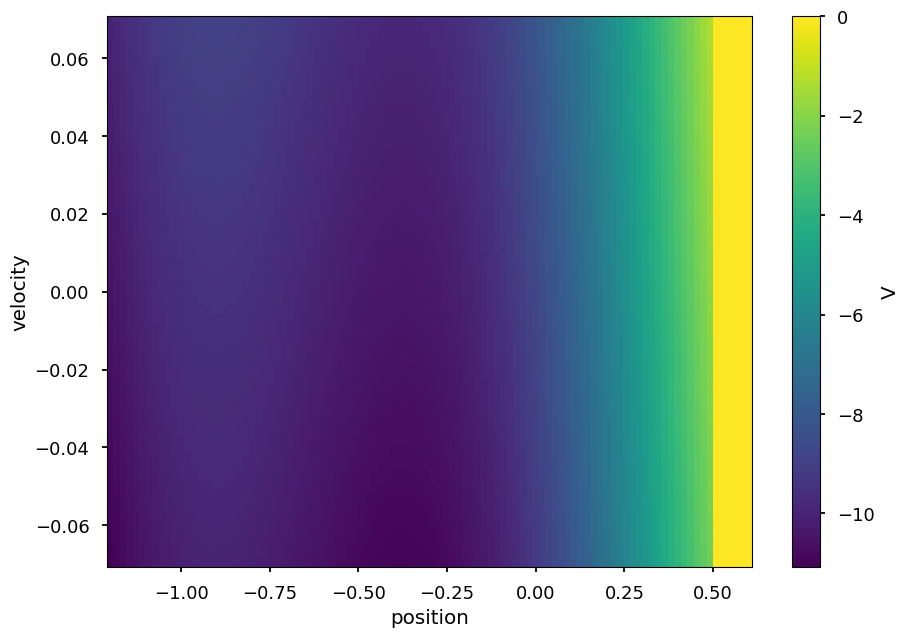

In [6]:
### This script will plot the value function as a colored map
resolution = 100

pos_vec = np.linspace(-1.2, 0.6, resolution)
vel_vec = np.linspace(-0.07, 0.07, resolution)

pos_mat, vel_mat = np.meshgrid(pos_vec, vel_vec)
value_mat = np.zeros([resolution, resolution])

for pos_idx, pos in enumerate(tqdm(pos_vec)):
    for vel_idx, vel in enumerate(vel_vec):
        feat_state = feature(np.array([pos, vel]))
        value_mat[vel_idx, pos_idx] = forward(w, feat_state)

# Plot
plt.pcolormesh(pos_mat, vel_mat, value_mat)
plt.xlabel("position")
plt.ylabel("velocity")
cbar = plt.colorbar()
cbar.set_label("V")

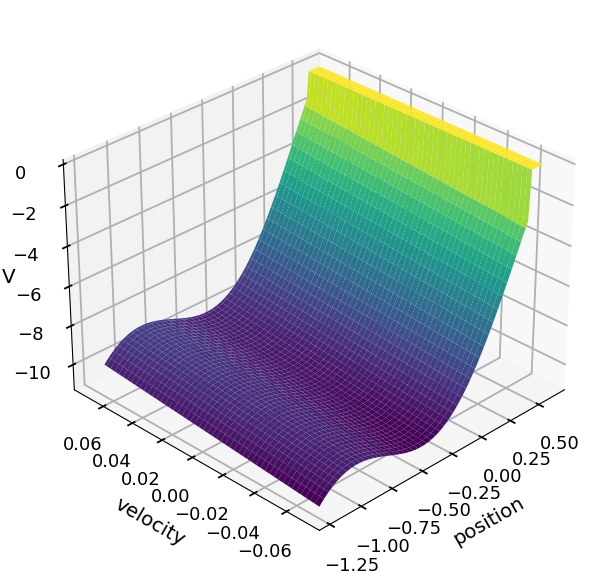

In [7]:
### This script will plot the value function as a surface
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(pos_mat, vel_mat, np.squeeze(value_mat), cmap="viridis")
ax.set_xlabel('\n\nposition')
ax.set_ylabel('\n\nvelocity')
ax.set_zlabel('V')

ax.view_init(30, -135)

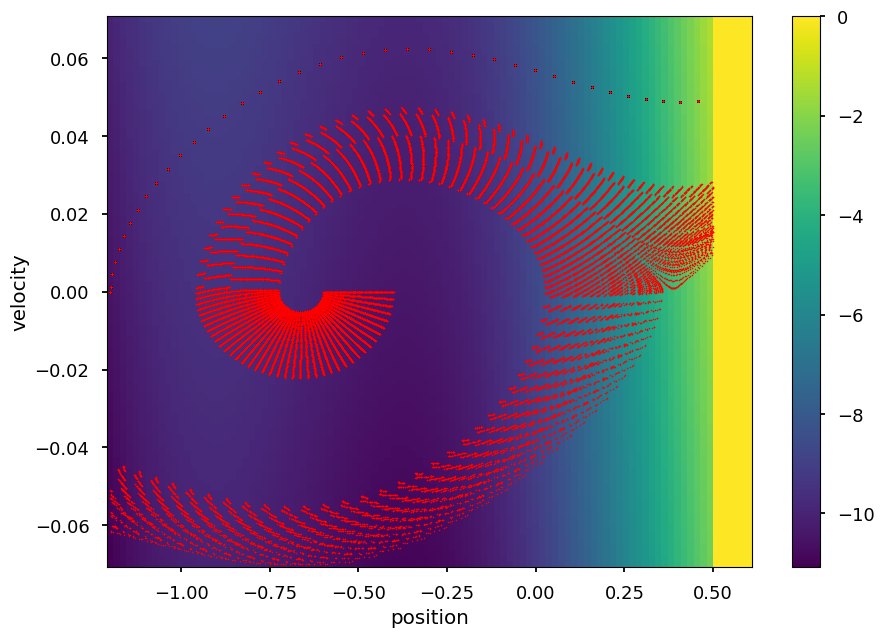

In [8]:
plt.pcolormesh(pos_mat, vel_mat, value_mat)
visited_states = np.array(visited_states)
plt.xlabel("position")
plt.ylabel("velocity")
plt.colorbar()
plt.scatter(visited_states[:, 0], visited_states[:, 1], color="red", s=0.5)
cbar.set_label("V")

## 2) Recursive Least Squares TD

In the previous task we computed the parameters of the value function iteratively, by using old parameters and new observations to calculate new parameters. This works, but we can also be more data efficient. Recursive Least Squares Temporal Difference Learning (RLS-TD) allows to determine new parameters on the basis of new AND old observations, such that the parameters we receive are optimally fitted while taking past experiences into account. This method does not use a step size but only a forgetting factor $\lambda \in [0,1]$ which defines the impact of past experiences. 

Write an RLS-TD algorithm to solve the prediction problem. Check the stability of your code for the forgetting factors $\lambda \in \{0.9, 0.99, 1\}$. As this algorithm contains a lot of matrix multiplication, pay attention to vectors being represented within the correct dimensions. One could e.g. use the `row_vector.reshape(-1, 1)` command to turn a row vector into a column vector, or use the postix `.T` to transpose an array (note, this has no effect on one-dimensional arrays).

The feature definition from task (1) can be reused here as long as $\tilde{\mathbf{x}}_T = \mathbf{0}$ holds.

**Hint:** `interact` and `forward` from 1) can be reused in this task as well. For the use of `forward`, you only need to ensure that `w` is shaped properly.

In [9]:
def feature(state):
    pos, vel = state
    win = int(pos > 0.5)
    ### BEGIN SOLUTION
    
    pos_max = 0.6
    pos_min = -1.2
    vel_max = 0.07
    vel_min = -0.07

    minmax_normalization = False
    if minmax_normalization:
        pos = (pos - pos_min) / (pos_max - pos_min) * 2 - 1
        vel = (vel - vel_min) / (vel_max - vel_min) * 2 - 1
    
    feature_vec = np.array([
        1, 
        pos, 
        vel,
        vel ** 2,
        np.sin(3 * pos), # height, already in [-1, 1]
        np.cos(3 * pos), # gravity, already in [-1, 1]
    ]) * (1 - win)

    ### END SOLUTION
    
    return feature_vec

In [10]:
def learn(w, P, state, next_state, reward, _lambda, gamma, ident_mat):
    """Learns from the interaction via RLS-TD.

    Args:
        w: The parameters of your state-value estimator
        P: Covariance matrix of the last step
        state: The state of the environment before interaction
        next_state: The state of the environment after interaction
        reward: The reward for the interaction
        _lambda: Forgetting factor
        gamma: Discount factor
        ident_mat: The identity matrix for you feature dimension

    Returns:
        w: The updated parameter vector
        P: The updated covariance matrix
    """
    ### BEGIN SOLUTION
    feat_state = np.expand_dims(feature(state), axis=-1)
    feat_next_state = feature(next_state).reshape(-1, 1)

    # the RLS-TD update
    y = reward      
    xi = feat_state - gamma * feat_next_state
    c = (P @ xi) / (_lambda + np.squeeze(xi.T @ P @ xi))
    w += c * np.squeeze(y - xi.T @ w)
    P = (ident_mat - c @ xi.T) @ P / _lambda
    
    ### END SOLUTION

    return w, P

In [11]:
gamma = 0.9
_lambda = 1 # we call it like that because "lambda" is a built-in command/ reserved syntax in python
nb_episodes = 500

env = gym.make('MountainCar-v0')
state, _ = env.reset()
feat_state = feature(state)
feat_dims = len(feat_state)

P = np.eye(feat_dims)
w = np.zeros((feat_dims, 1))  # column vector
ident_mat = np.eye(feat_dims)  # identity matrix

for j in tqdm(range(nb_episodes)):
    
    ### BEGIN SOLUTION
    
    state, _ = env.reset()

    while True:
        #env.render()

        next_state, reward, done = interact(state)

        w, P = learn(w, P, state, next_state, reward, _lambda, gamma, ident_mat)
        
        # time propagation
        state = next_state

        if done:
            break
        
    env.close()
    
print(w)

### END SOLUTION

  0%|          | 0/500 [00:00<?, ?it/s]

[[-5.49135683]
 [ 7.50847428]
 [ 8.28842666]
 [ 1.09568374]
 [ 0.60980846]
 [-3.28021685]]


To simplify the comparison with your results from task (1), visualize the results from this task as well.

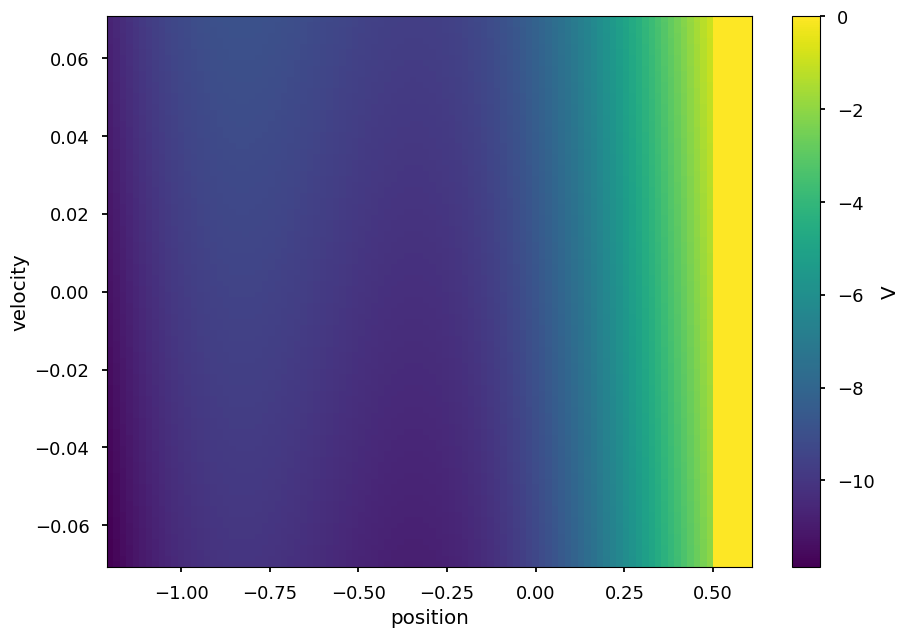

In [12]:
# create a meshgrid on the state space
pos_vec = np.linspace(-1.2, 0.6, 100)
vel_vec = np.linspace(-0.07, 0.07, 100)

pos_mat, vel_mat = np.meshgrid(pos_vec, vel_vec)
value_mat = np.zeros([100, 100])

for pos_idx, pos in enumerate(pos_vec):
    for vel_idx, vel in enumerate(vel_vec):
        feat_state = feature(np.array([pos, vel]))
        feat_state = np.expand_dims(feat_state, axis = -1)
        value_mat[vel_idx, pos_idx] = forward(w.T, feat_state)

# Plot
plt.pcolormesh(pos_mat, vel_mat, value_mat)
plt.xlabel("position")
plt.ylabel("velocity")
cbar = plt.colorbar()
cbar.set_label("V")

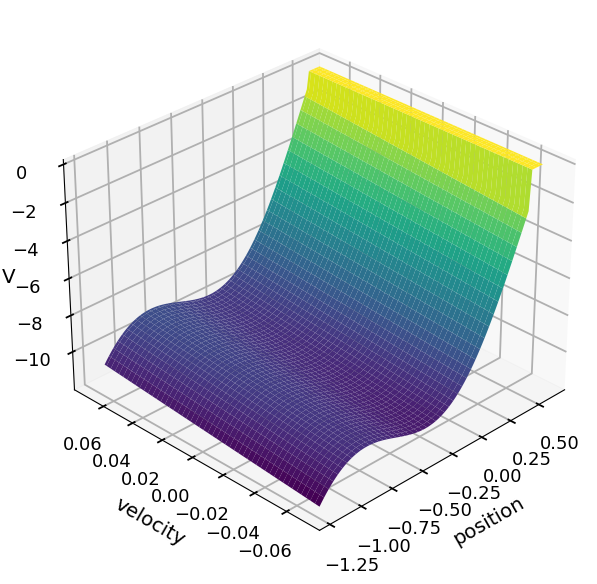

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(pos_mat, vel_mat, np.squeeze(value_mat), cmap="viridis")
ax.set_xlabel('\n\nposition')
ax.set_ylabel('\n\nvelocity')
ax.set_zlabel('V')
ax.view_init(30, -135)

## 3) Nonlinear Function Approximation with Artificial Neural Networks

Maybe we can achieve a more precise value estimation if we use a nonlinear function approximator. The dynamics of the environment are nonlinear, so it would be reasonable to expect a better result. We will use an artificial neural network as our function approximator without feature engineering. 

Neural networks tend to learn more reliably if the input variables are normalized. In this case, we will use minmax normalization. Write the function `normalize` that normalizes the MounatinCar state:

\begin{align}
\text{state}&\in
\begin{bmatrix}
[-1.2, 0.6] \\
[-0.07, 0.07]
\end{bmatrix}
\\
\text{normalize(state)}&\in
\begin{bmatrix}
[-1, 1] \\
[-1, 1]
\end{bmatrix}
\end{align}

`PyTorch` is somewhat complicated to understand if you are new to it and efficient usage of it in reinforcement learning looks different from the usage in "traditional" supervised learning. That is why we prepared the code for the network training this time. You only need to write a proper `normalize` function here, but of course feel free to explore the learning algorithm (e.g. experiment with different ANN topologies) as a preparation for the upcoming exercises. A more detailed explanation about the usage of `PyTorch` in this task will be presented in the corresponding tutorial (video).

In [14]:
### BEGIN SOLUTION
pos_min = -1.2
pos_max = +0.6
vel_min = -0.07
vel_max = +0.07
min_arr = np.array([[pos_min, vel_min]])
denom = np.array([[pos_max, vel_max]]) - min_arr
### END SOLUTION

def normalize(state):
    ### BEGIN SOLUTION
    normed_state = (state - min_arr) / denom * 2 - 1
    ### END SOLUTION
    return normed_state

In [15]:
# Model definition
class FeedForwardNetwork(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        """Prediction of the state-value for the given state."""
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def learn(model, state, next_state, reward, gamma, optimizer, mse_loss):
    """Learns from the interaction via bootstrapping and backpropagation.
    
    Implement the semi-gradient method in which the estimate for the 
    state-value at the next state is compared to the estimate of the 
    state-value at the current state + the gathered reward.

    Args:
        model: The state-value prediction model
        state: The state of the environment before interaction
        next_state: The state of the environment after interaction
        reward: The reward for the interaction
        gamma: Discount factor

    Returns:
        loss: The loss for the current learning step
    """
    ### BEGIN SOLUTION
    norm_state = torch.tensor(normalize(state), dtype=torch.float32)
    norm_next_state = torch.tensor(normalize(next_state), dtype=torch.float32)

    with torch.no_grad():
        next_value = model(norm_next_state)

    target = torch.tensor([[reward]], dtype=torch.float32)
    if not done:
        target += gamma * next_value

    # Calculate loss
    prediction = model(torch.tensor(norm_state, dtype=torch.float32)[0])
    loss = mse_loss(target, prediction)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ### END SOLUTION

    return loss

In [16]:
# Environment setup
env = gym.make('MountainCar-v0')

# Hyperparameters
alpha = 0.0001
gamma = 0.9
nb_episodes = 1000
input_dim = env.observation_space.shape[0]

# Initialize model, optimizer, and loss function
model = FeedForwardNetwork(input_dim)
optimizer = optim.SGD(model.parameters(), lr=alpha)
mse_loss = nn.MSELoss()

# Training loop
errors = []
visited_states = []

for j in tqdm(range(nb_episodes)):
    state, _ = env.reset()

    while True:
        next_state, reward, done = interact(state)

        loss = learn(model, state, next_state, reward, gamma, optimizer, mse_loss)

        state = next_state
        
        errors.append(loss.item())
        visited_states.append(state)
        
        if done:
            break

visited_states = np.vstack(visited_states)

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\jakobeit\AppData\Local\Temp\ipykernel_22848\1278560270.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction = model(torch.tensor(norm_state, dtype=torch.float32)[0])
c:\Users\jakobeit\Anaconda3\envs\RLKurs2\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


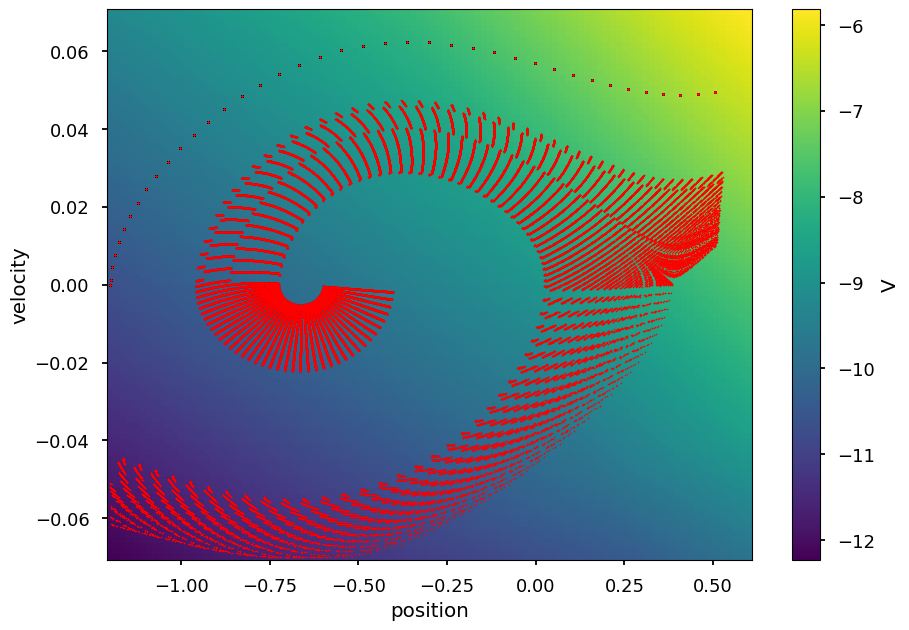

In [17]:
input_tensor = torch.tensor(np.column_stack([pos_mat.ravel(), vel_mat.ravel()]), dtype=torch.float32)
normalized_input = normalize(input_tensor).float()
value_mat = model(normalized_input).detach().numpy().reshape(pos_mat.shape)

# Plotting Code
plt.pcolormesh(pos_mat, vel_mat, value_mat)
plt.xlabel("position")
plt.ylabel("velocity")
cbar = plt.colorbar()
cbar.set_label("V")
_ = plt.scatter(visited_states[:, 0], visited_states[:, 1], color="red", s=0.5)

Try to  visualize the results from this task as well.

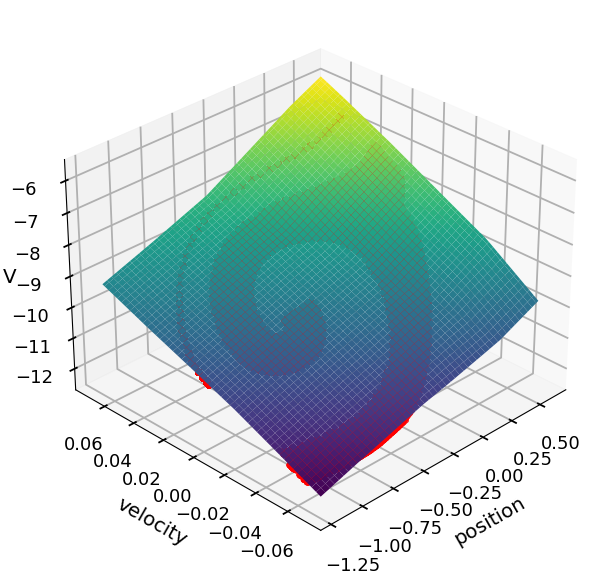

In [18]:
visited_states_tensor = torch.tensor(visited_states, dtype=torch.float32)
normalized_visited_states = normalize(visited_states_tensor).float()
visited_values = model(normalized_visited_states).detach().numpy()

# Plotting code
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(pos_mat, vel_mat, value_mat, cmap="viridis")
ax.scatter(visited_states[:, 0], visited_states[:, 1], np.squeeze(visited_values), color="red")
ax.set_xlabel('\n\nposition')
ax.set_ylabel('\n\nvelocity')
ax.set_zlabel('V')
ax.view_init(30, -135)